In [1]:
import numpy as np
import pandas as pd

In [2]:
turb_data=pd.read_csv('../../turb_data.csv')
turb_data

x_coord  y_coord  ref_wind_speed  wind_speed  turb_num  \
0        0.000000      0.0        4.359392           6         0   
1     2633.103635   -226.0        4.387136           6         1   
2       57.854836   -545.0        4.358929           6         2   
3        0.000000      0.0        4.355684           6         0   
4     1935.499403    264.0        4.383674           6         1   
...           ...      ...             ...         ...       ...   
3835   294.588246    -52.0       18.847122          20         1   
3836  1773.331277   -295.0       19.222500          20         2   
3837     0.000000      0.0       19.118147          20         0   
3838  3106.576695   -431.0       19.286488          20         1   
3839   624.261321   -139.0       19.148735          20         2   

      num_tot_turb                          ID  IDnum  
0                3  3_turbine_155th_simulation      0  
1                3  3_turbine_155th_simulation      0  
2                3  3_turbine_155th_simulation      0  
3                3  3_turbine_141th_simulation      1  
4                3  3_turbine_141th_simulation      1  
...            ...                         ...    ...  
3835             3   3_turbine_65th_simulation   1278  
3836             3   3_turbine_65th_simulation   1278  
3837             3   3_turbine_71th_simulation   1279  
3838             3   3_turbine_71th_simulation   1279  
3839             3   3_turbine_71th_simulation   1279  

[3840 rows x 8 columns]

In [3]:
dataset=turb_data.drop(['ID','turb_num'], axis=1)

In [4]:
import os
os.chdir("../..")
import descriptor.three_desc_model_nn as desc
from descriptor.cutoffs import Polynomial
import matplotlib.pyplot as plt
import GPy
from IPython.display import display
symbol="Siemens"
turb = [symbol]
numsims=dataset["IDnum"].iloc[-1]+1

In [5]:
def build_and_compile_model(norm, l2_reg=0.001):
    model = keras.Sequential([
        norm,
        layers.Dense(64, activation='relu', kernel_regularizer=regularizers.l2(l2_reg)),
        layers.Dense(64, activation='relu', kernel_regularizer=regularizers.l2(l2_reg)),
        layers.Dense(32, activation='relu', kernel_regularizer=regularizers.l2(l2_reg)),
        layers.Dense(16, activation='relu', kernel_regularizer=regularizers.l2(l2_reg)),
        layers.Dense(1)
    ])
    model.compile(loss='mean_absolute_error', optimizer=tf.keras.optimizers.Adam(0.0001), metrics=['mse'])
    return model

In [6]:
Gs = desc.make_symmetry_functions(turbines=symbol, type='G2',
                                    etas=np.linspace(1,10, 5),
                                    offsets=[0])
Gs += desc.make_symmetry_functions(turbines=symbol, type='G4',
                                     etas=np.linspace(1,10,5),
                                     gammas=np.linspace(1,10,5))
Gs += desc.make_symmetry_functions(turbines=symbol, type='G6',
                                     etas=np.linspace(1,10, 5),
                                     gammas=np.linspace(1,10, 5))

In [7]:
len(Gs)

55

In [8]:
Gs

[{'type': 'G2', 'turbine': 'Siemens', 'eta': 1.0, 'offset': 0},
 {'type': 'G2', 'turbine': 'Siemens', 'eta': 3.25, 'offset': 0},
 {'type': 'G2', 'turbine': 'Siemens', 'eta': 5.5, 'offset': 0},
 {'type': 'G2', 'turbine': 'Siemens', 'eta': 7.75, 'offset': 0},
 {'type': 'G2', 'turbine': 'Siemens', 'eta': 10.0, 'offset': 0},
 {'type': 'G4', 'turbine': 'Siemens', 'eta': 1.0, 'gamma': 1.0},
 {'type': 'G4', 'turbine': 'Siemens', 'eta': 1.0, 'gamma': 3.25},
 {'type': 'G4', 'turbine': 'Siemens', 'eta': 1.0, 'gamma': 5.5},
 {'type': 'G4', 'turbine': 'Siemens', 'eta': 1.0, 'gamma': 7.75},
 {'type': 'G4', 'turbine': 'Siemens', 'eta': 1.0, 'gamma': 10.0},
 {'type': 'G4', 'turbine': 'Siemens', 'eta': 3.25, 'gamma': 1.0},
 {'type': 'G4', 'turbine': 'Siemens', 'eta': 3.25, 'gamma': 3.25},
 {'type': 'G4', 'turbine': 'Siemens', 'eta': 3.25, 'gamma': 5.5},
 {'type': 'G4', 'turbine': 'Siemens', 'eta': 3.25, 'gamma': 7.75},
 {'type': 'G4', 'turbine': 'Siemens', 'eta': 3.25, 'gamma': 10.0},
 {'type': 'G4', 

In [9]:
# Gs = {"Siemens": [{"type":"G2", "turbine":"Siemens","eta":4.25387599, "offset": 1.0151402},
#                   {"type":"G4", "elements":"Siemens","eta":2.56450515, "gamma":8.04475192},
#                   {"type":"G6", "elements":"Siemens","eta":2.33043463, "gamma": 0.50753377}
#                  ]}

In [10]:
# Gs = {"Siemens": [{"type":"G2", "turbine":"Siemens","eta":3.24310834, "offset": 1.9817547},
#                   {"type":"G4", "elements":"Siemens","eta":2.48579287, "gamma":12.39114317},
#                   {"type":"G6", "elements":"Siemens","eta":1.27537145, "gamma": 0.2110151}
#                  ]}

In [11]:
nl=desc.NeighborlistCalculator(cutoff=4001,cone_grad=0.12582561117875557, cone_offset=72.24947126849844)
finpr=desc.FingerprintCalculator(cutoff=4001,Gs=Gs,Rct=3000,delta_R=100,cone_grad=0.12582561117875557, cone_offset=72.24947126849844)
count=0
dataset_fp=np.empty(shape=(0, len(Gs)))
dataset_rws=np.empty(shape=(0, 1))
dataset_ws=np.empty(shape=(0, 1))
dataset_pos=np.empty(shape=(0, 2))
for i in range(numsims):
    numturb=dataset["num_tot_turb"].iloc[count]
    position = np.empty((numturb,2))
    rws = np.empty((numturb,1))
    ws = np.empty((numturb,1))
    fp = np.empty((numturb,3))
    for k in range(numturb):
        position[k,0]=dataset["x_coord"].iloc[count]
        position[k,1]=dataset["y_coord"].iloc[count]
        rws[k,0]=dataset["ref_wind_speed"].iloc[count]
        ws[k,0]=dataset["wind_speed"].iloc[count]
        count = count+ 1
    neigh=nl.calculate(turb*numturb,position)
    fingerprints=finpr.calculate(turb*numturb,position,neigh,symbol)
    fingerprints=np.array(fingerprints)
    dataset_fp=np.append(dataset_fp,fingerprints,axis=0)
    dataset_rws=np.append(dataset_rws,rws,axis=0)
    dataset_ws=np.append(dataset_ws,ws,axis=0)
    dataset_pos=np.append(dataset_pos,position,axis=0)
all_data=np.concatenate((dataset_fp, dataset_ws, dataset_rws),axis=1)
all_data = pd.DataFrame(all_data)#, columns = ['Fingerprint(G2)','Fingerprint(G4)','Fingerprint(G6)','Ref_Wind_Speed','Wind_Speed'])

train_data = all_data.sample(frac=0.8, random_state=0)
test_data = all_data.drop(train_data.index)

X_train = train_data.iloc[:,:-1]
X_test = test_data.iloc[:,:-1]
X = all_data.iloc[:,:-1]

Y_train = train_data.iloc[:,-1]
Y_test = test_data.iloc[:,-1]
Y = all_data.iloc[:,-1]

In [12]:
import tensorflow as tf
import matplotlib.pyplot as plt
import keras
from tensorflow.keras import layers, callbacks, regularizers
from tensorflow.keras.layers.experimental import preprocessing
from sklearn.model_selection import train_test_split
normalizer = preprocessing.Normalization(axis=-1)
normalizer.adapt(np.array(X_train))

2023-08-01 19:04:41.049420: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [13]:


def train_model(model, X_train, y_train, X_val, y_val, batch_size=32):
    early_stopping = callbacks.EarlyStopping(monitor='val_loss', mode='min', patience=100, restore_best_weights=True)
    
    history = model.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=10000, callbacks=[early_stopping], batch_size=batch_size)

    return history

In [14]:
from sklearn.model_selection import KFold
from keras.callbacks import EarlyStopping, LearningRateScheduler

def lr_schedule(epoch):
    initial_lr = 0.0001
    drop = 0.5
    epochs_drop = 50
    return initial_lr * drop ** (epoch // epochs_drop)

def train_model_with_cross_validation(model, X, y, batch_size=32, n_splits=5, epochs=10000):
    kf = KFold(n_splits=n_splits, shuffle=True, random_state=42)
    histories = []
    print(enumerate(kf.split(X, y)))

    for train_index, val_index in kf.split(X.reset_index()):
        X_train, X_val = X[train_index], X[val_index]
        y_train, y_val = y[train_index], y[val_index]

        early_stopping = EarlyStopping(monitor='val_loss', mode='min', patience=100, restore_best_weights=True)

        lr_scheduler = LearningRateScheduler(lr_schedule)

        history = model.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=epochs, callbacks=[early_stopping, lr_scheduler], batch_size=batch_size)
        histories.append(history)

    return histories

In [15]:
dnn_model = build_and_compile_model(normalizer)
dnn_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 normalization (Normalizatio  (None, 56)               113       
 n)                                                              
                                                                 
 dense (Dense)               (None, 64)                3648      
                                                                 
 dense_1 (Dense)             (None, 64)                4160      
                                                                 
 dense_2 (Dense)             (None, 32)                2080      
                                                                 
 dense_3 (Dense)             (None, 16)                528       
                                                                 
 dense_4 (Dense)             (None, 1)                 17        
                                                        

In [16]:
x_train, x_val, y_train, y_val = train_test_split(X_train, Y_train, test_size=0.1, random_state=42)
history = train_model(dnn_model, x_train,y_train, x_val, y_val, batch_size=32)

Epoch 1/10000
87/87 [==============================] - 1s 3ms/step - loss: 9.7189 - mse: 113.1187 - val_loss: 8.6999 - val_mse: 92.4576
Epoch 2/10000
87/87 [==============================] - 0s 1ms/step - loss: 7.8215 - mse: 80.5708 - val_loss: 5.9613 - val_mse: 52.7130
Epoch 3/10000
87/87 [==============================] - 0s 2ms/step - loss: 4.9766 - mse: 40.3696 - val_loss: 3.9600 - val_mse: 26.6446
Epoch 4/10000
87/87 [==============================] - 0s 1ms/step - loss: 4.0156 - mse: 27.1931 - val_loss: 3.4393 - val_mse: 20.8025
Epoch 5/10000
87/87 [==============================] - 0s 1ms/step - loss: 3.4692 - mse: 19.9687 - val_loss: 2.9738 - val_mse: 15.5799
Epoch 6/10000
87/87 [==============================] - 0s 1ms/step - loss: 2.8635 - mse: 13.4676 - val_loss: 2.4409 - val_mse: 10.0233
Epoch 7/10000
87/87 [==============================] - 0s 2ms/step - loss: 2.1455 - mse: 7.6461 - val_loss: 1.7346 - val_mse: 5.2069
Epoch 8/10000
87/87 [==============================] - 0

In [17]:
# %%time
# history = dnn_model.fit(
#     train_features, train_labels,
#     validation_split=0.2,
#     verbose=0, epochs=10000)

In [37]:
def plot_loss(history):
    plt.figure(dpi=1200)
    plt.plot(history.history['loss'], label='train_error', color='C0')
    plt.plot(history.history['val_loss'], label='validation_error', color='C1')
    plt.ylim([0, 1])
    plt.xlabel('Epoch')
    plt.ylabel('Absolute Error [m/s]')
    plt.legend()
    
    plt.grid(True)

In [35]:
def plot_loss_mse(history):
    plt.plot(history.history['mse'], label='train_mse', color='C0')
    plt.plot(history.history['val_mse'], label='validation_mse', color='C1')
    plt.ylim([0, 1])
    plt.xlabel('Epoch')
    plt.ylabel('Absolute Error [m/s]')
    plt.legend()
    plt.figure(dpi=1200)
    plt.grid(True)

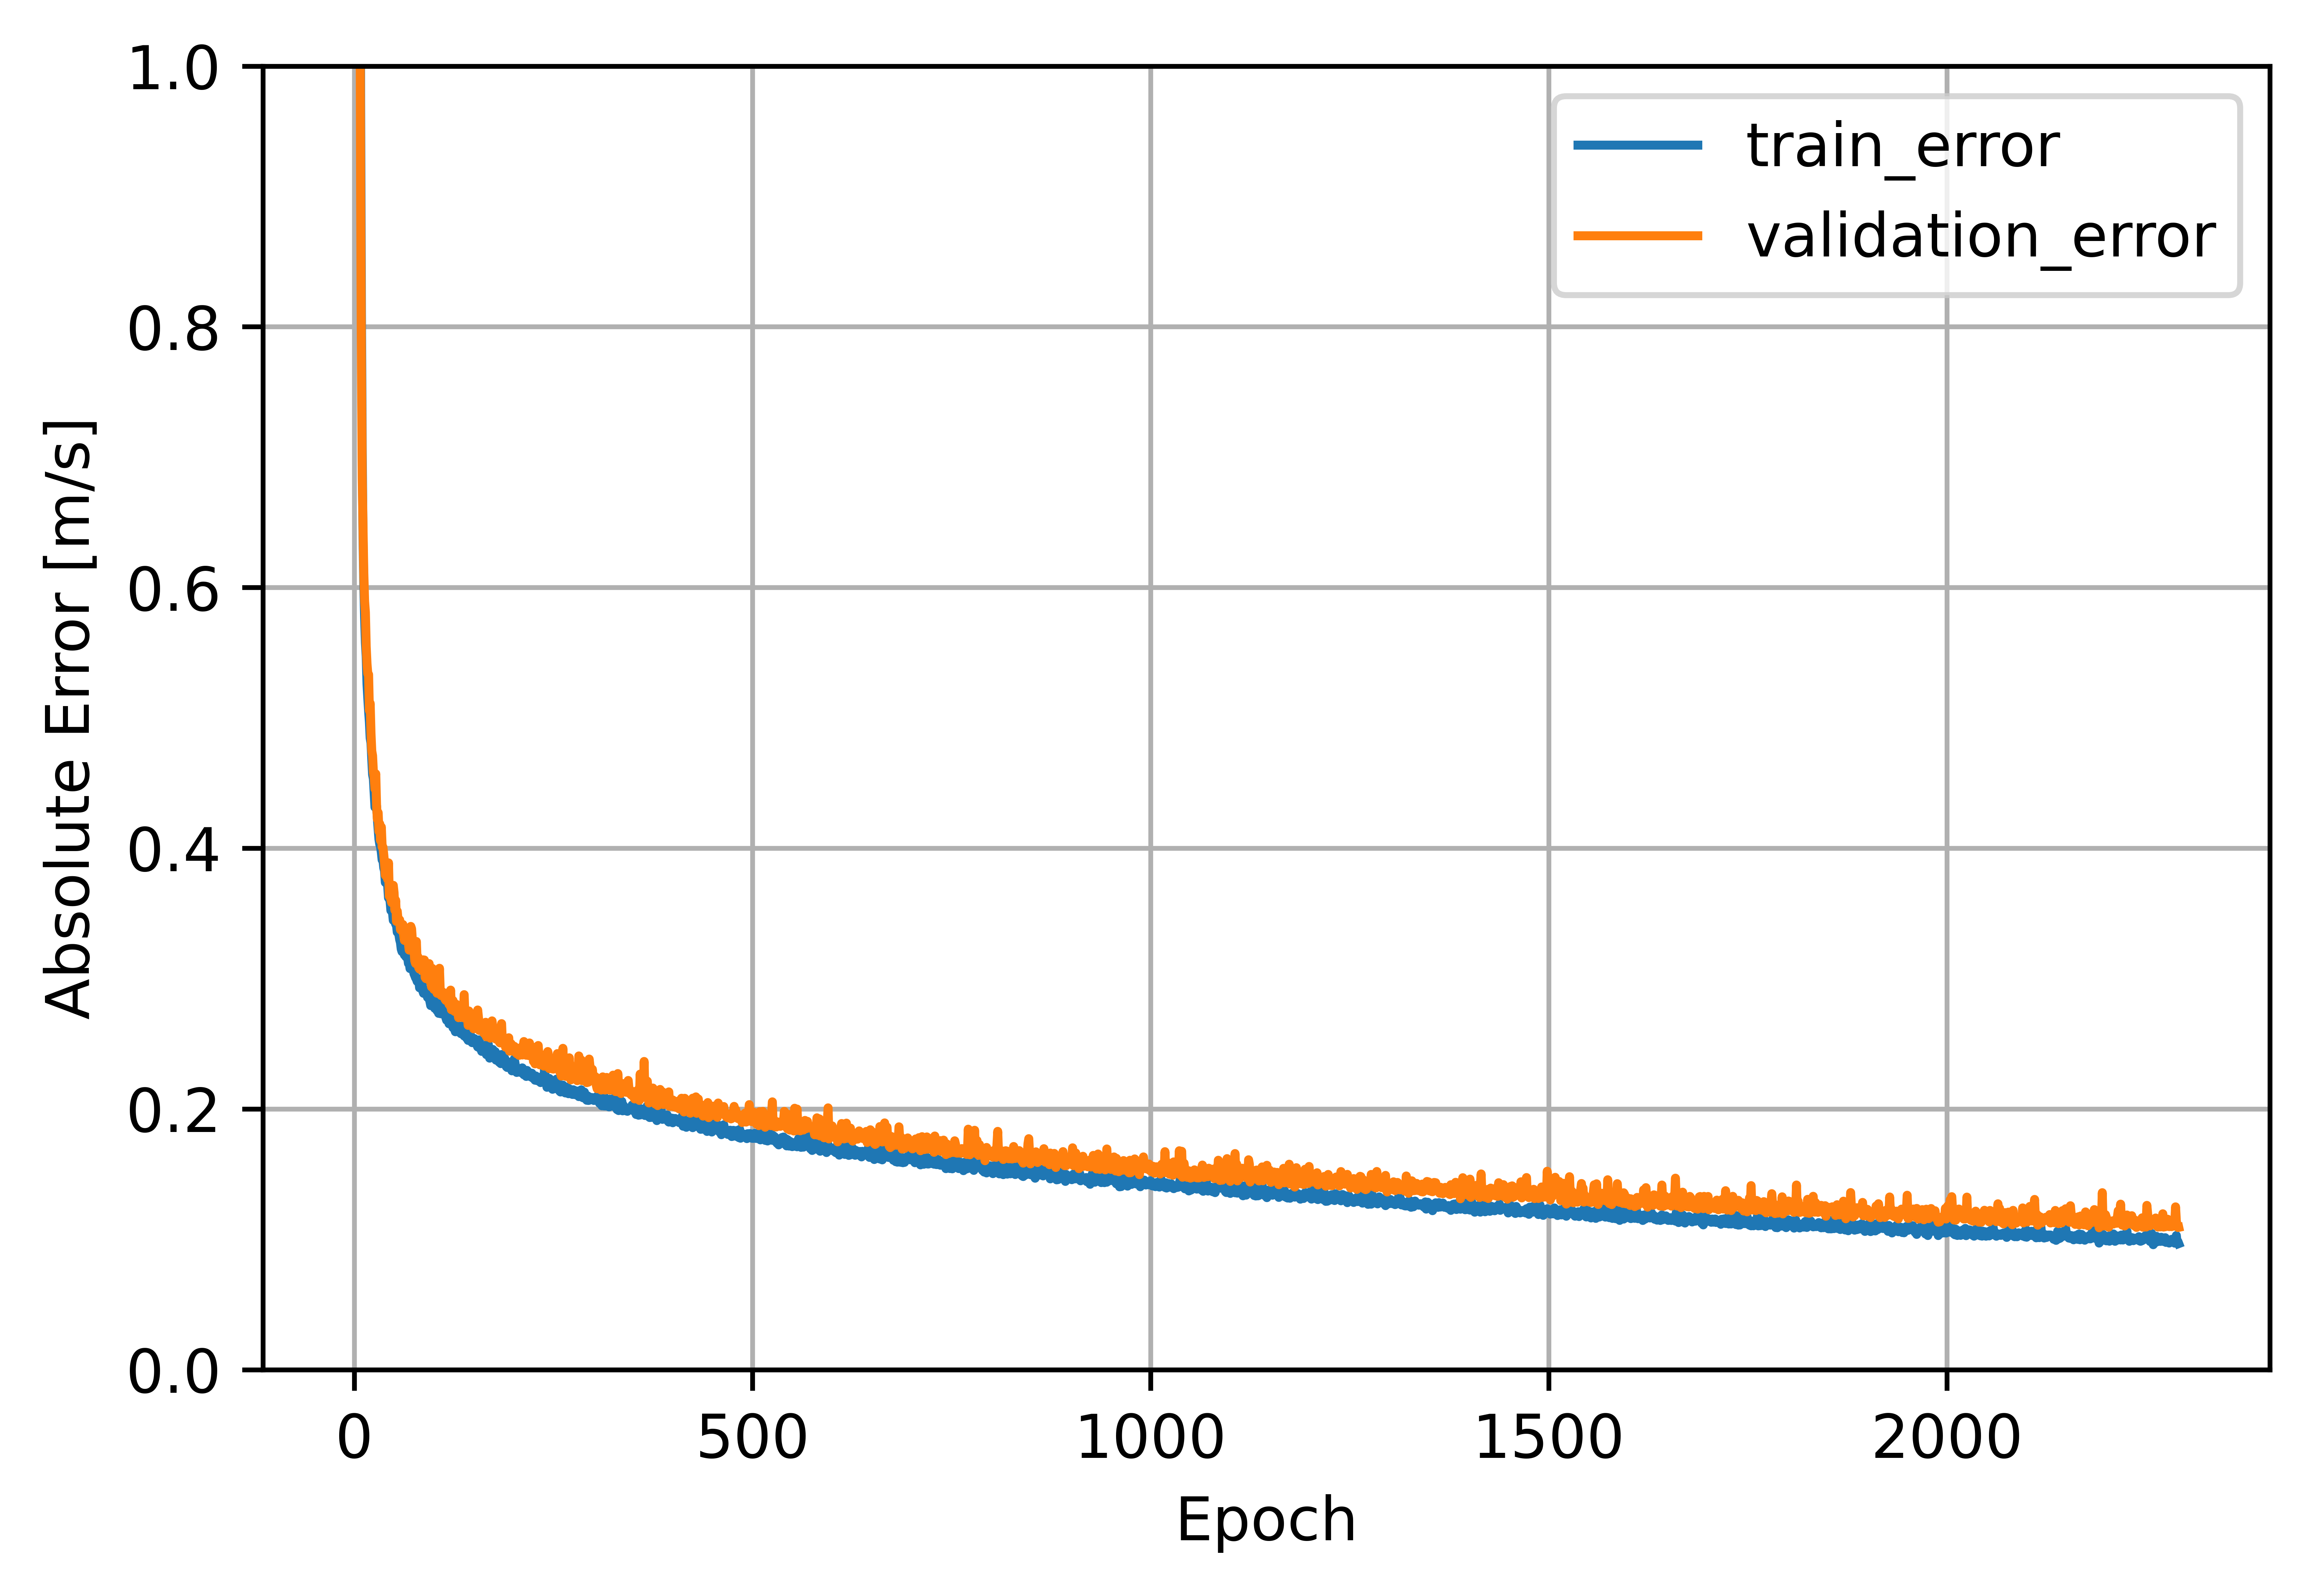

In [38]:
plot_loss(history)

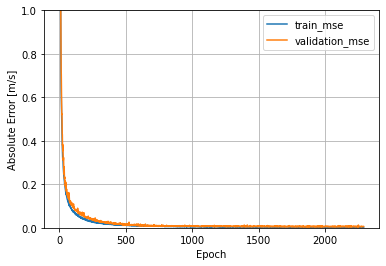

In [21]:
plot_loss_mse(history)

In [52]:
list(set(X.iloc[:,-1]))

[6.0, 8.0, 10.0, 12.0, 14.0, 16.0, 18.0, 20.0]

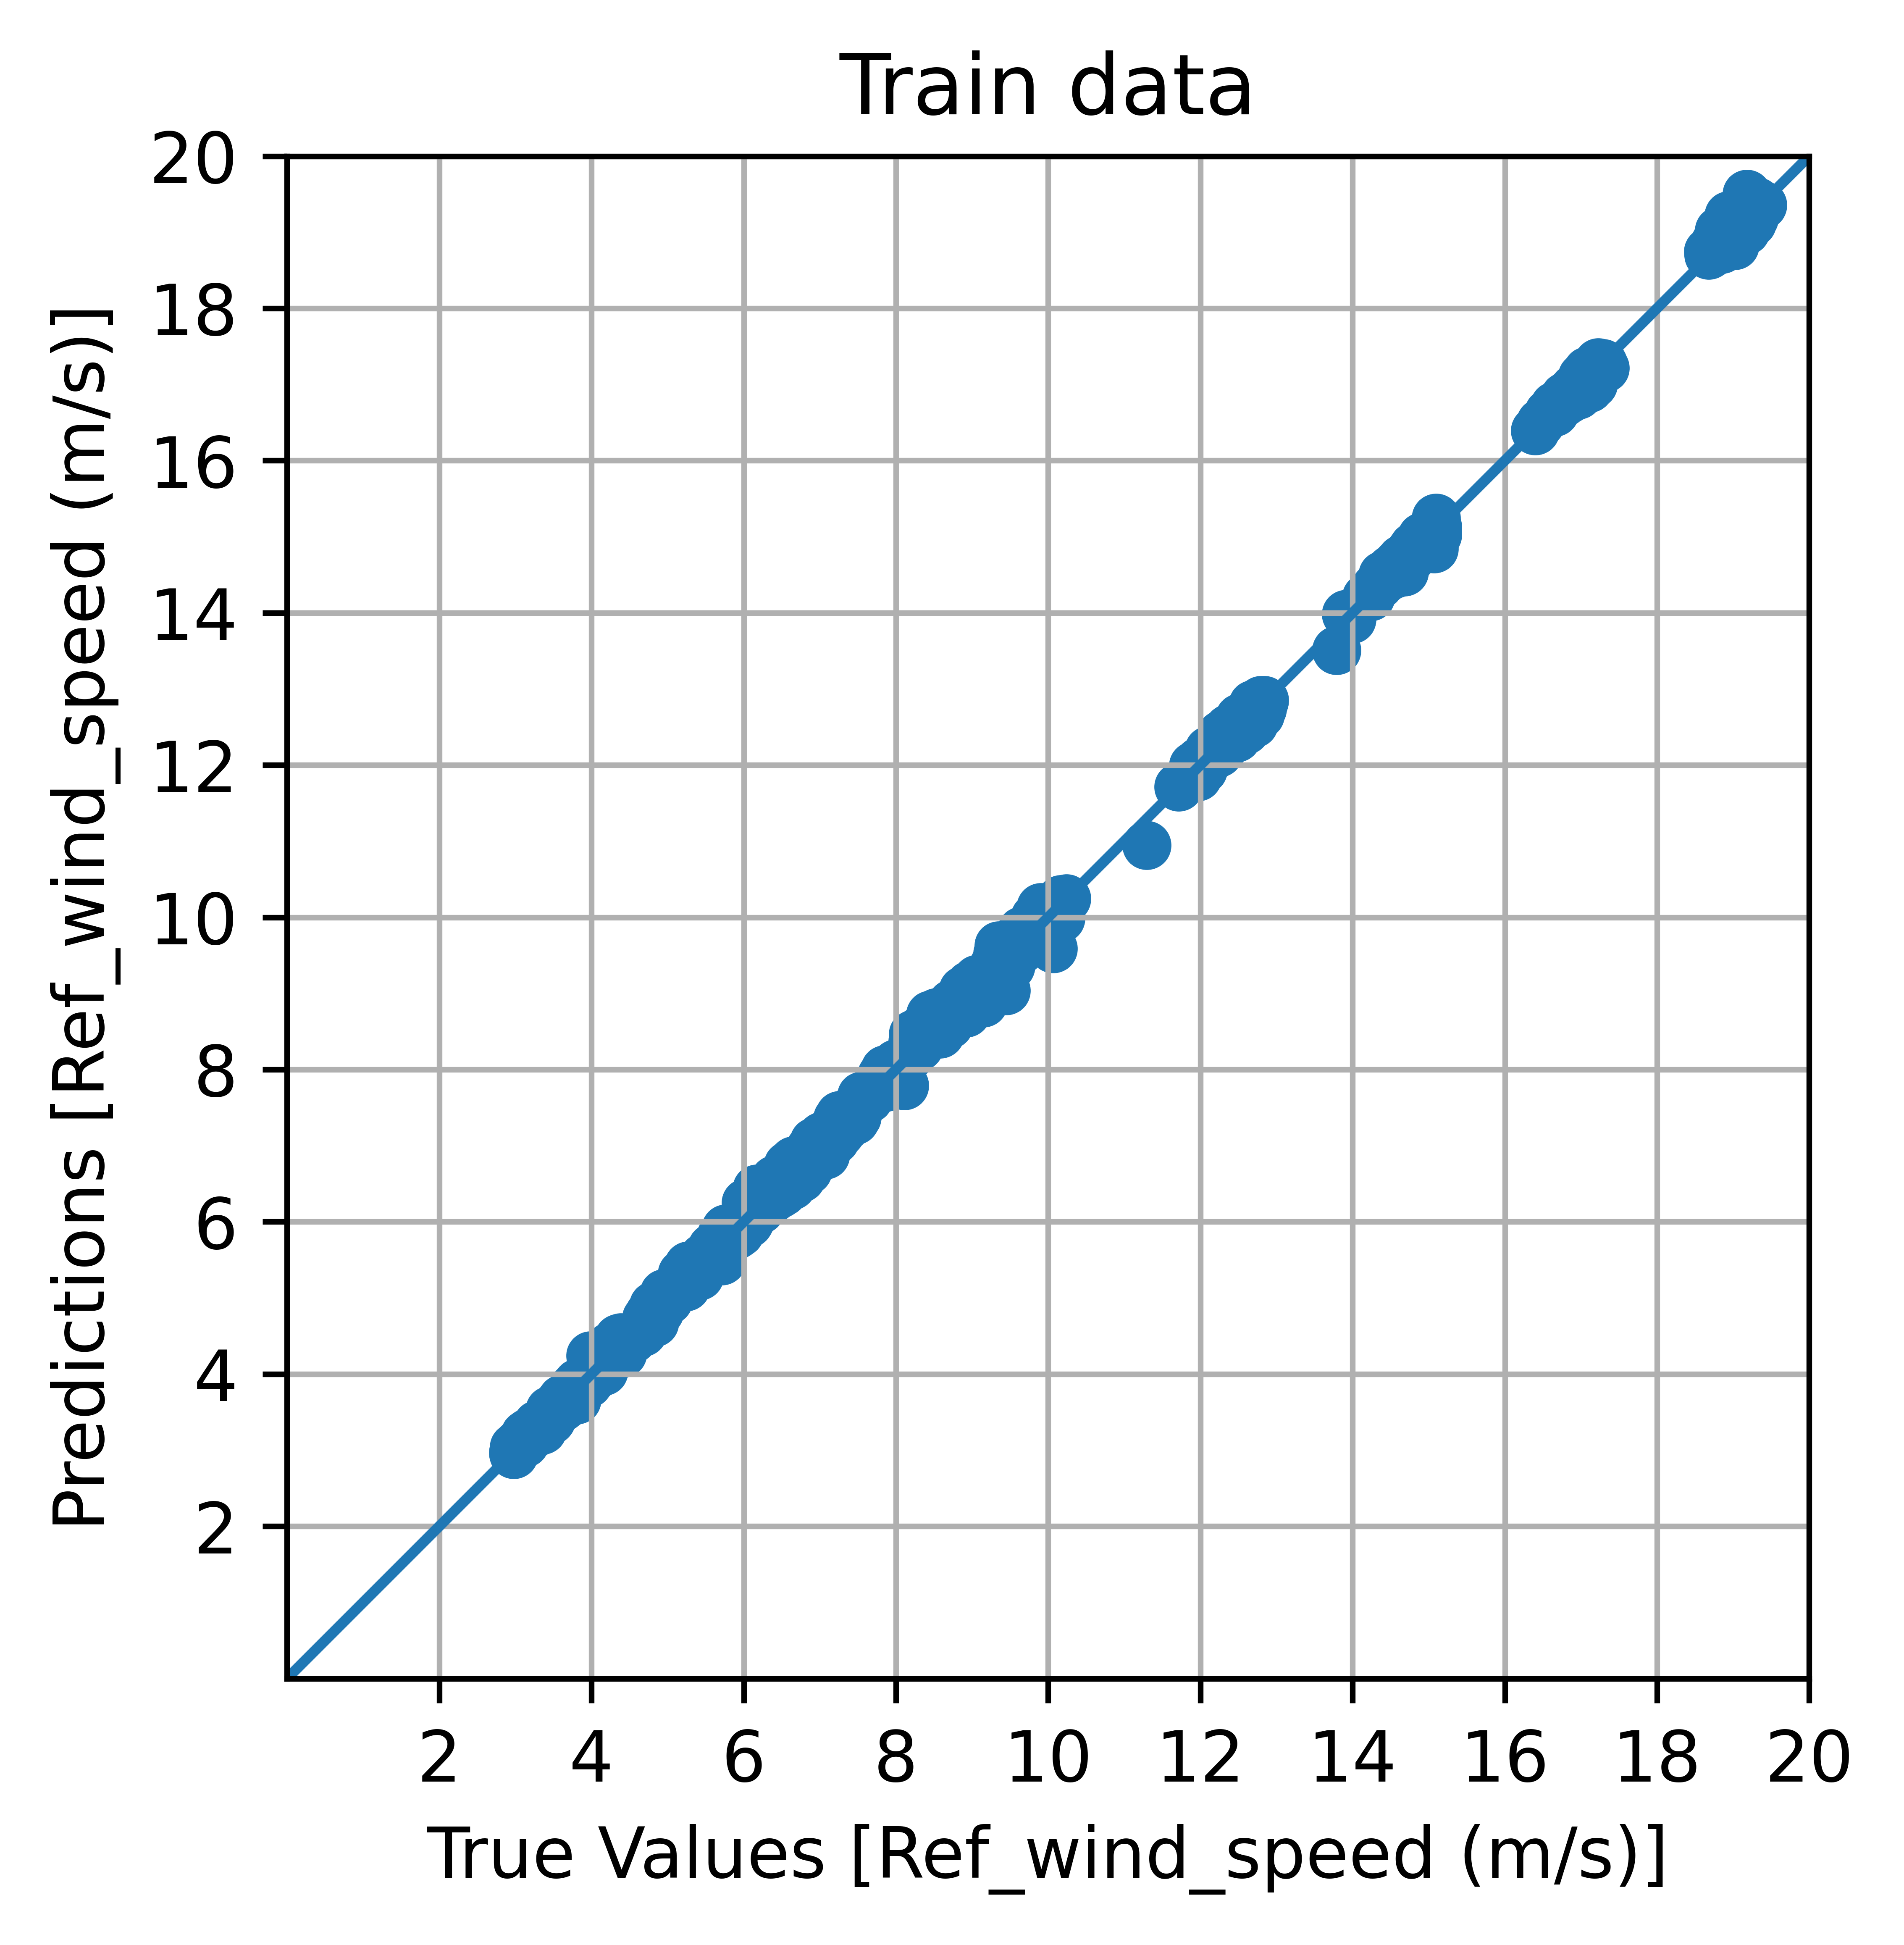

In [59]:
test_predictions = dnn_model.predict(X_test).flatten()
train_predictions = dnn_model.predict(X_train).flatten()
all_predictions = dnn_model.predict(X).flatten()
#test_predictions_0 = dnn_model.predict(test_features["Fingerprint(G2)"]==0).flatten()
#train_predictions_0 = dnn_model.predict(train_features["Fingerprint(G2)"]==0).flatten()
plt.figure(dpi=1200)

a = plt.axes(aspect='equal')
#plt.scatter(test_labels, test_predictions)#,c=test_features["Fingerprint(G2)"])
#plt.scatter(train_labels, train_predictions)#,c=train_features["Fingerprint(G2)"])
plt.scatter(Y_train, train_predictions)
plt.xlabel('True Values [Ref_wind_speed (m/s)]')
plt.ylabel('Predictions [Ref_wind_speed (m/s)]')
plt.title('Train data')
#cbar=plt.colorbar()
#cbar.set_label('Fingerprint(G2)')
lims = [0, 20]
plt.xlim(lims)
plt.ylim(lims)
plt.grid(True)
plt.xticks([2.0, 4.0, 6.0, 8.0, 10.0, 12.0, 14.0, 16.0, 18.0, 20.0])
plt.yticks([2.0, 4.0, 6.0, 8.0, 10.0, 12.0, 14.0, 16.0, 18.0, 20.0])
_ = plt.plot(lims, lims)

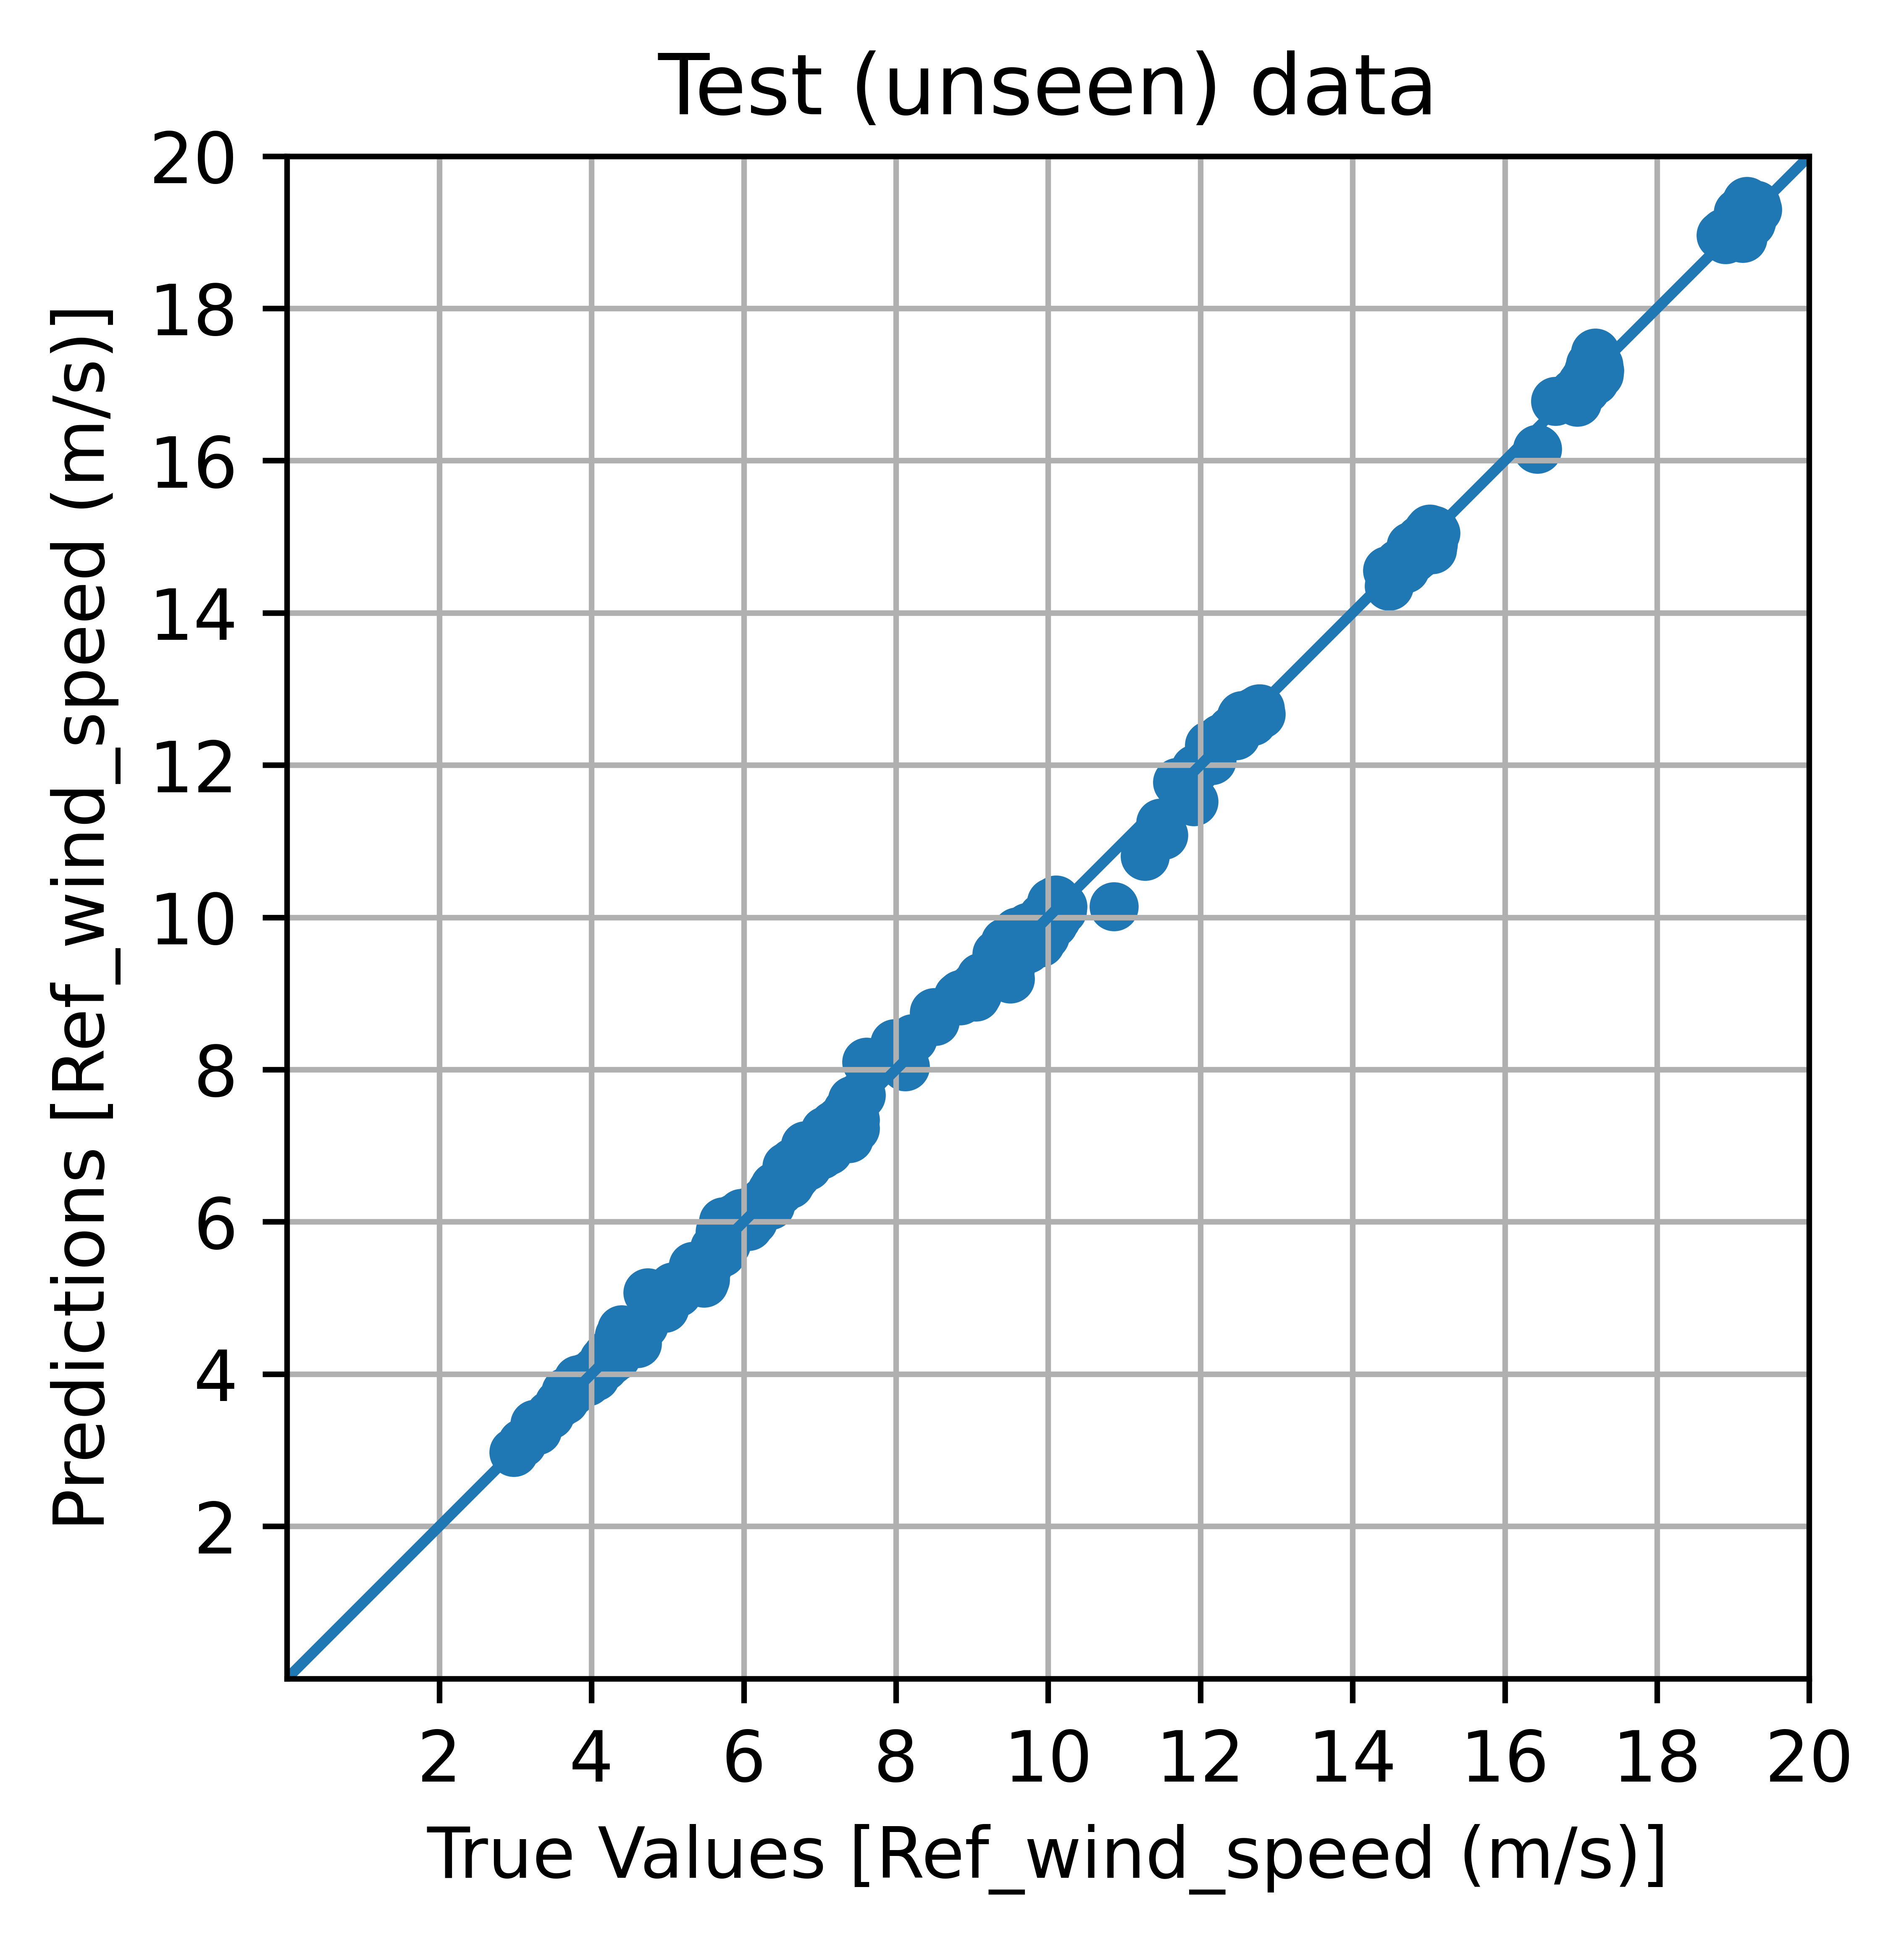

In [60]:
plt.figure(dpi=1200)
a = plt.axes(aspect='equal')
#plt.scatter(test_labels, test_predictions)#,c=test_features["Fingerprint(G2)"])
#plt.scatter(train_labels, train_predictions)#,c=train_features["Fingerprint(G2)"])
plt.scatter(Y_test, test_predictions)
plt.xlabel('True Values [Ref_wind_speed (m/s)]')
plt.ylabel('Predictions [Ref_wind_speed (m/s)]')
plt.title('Test (unseen) data')
#cbar=plt.colorbar()
#cbar.set_label('Fingerprint(G2)')
lims = [0, 20]
plt.xlim(lims)
plt.ylim(lims)
plt.grid(True)
plt.xticks([2.0, 4.0, 6.0, 8.0, 10.0, 12.0, 14.0, 16.0, 18.0, 20.0])
plt.yticks([2.0, 4.0, 6.0, 8.0, 10.0, 12.0, 14.0, 16.0, 18.0, 20.0])
_ = plt.plot(lims, lims)

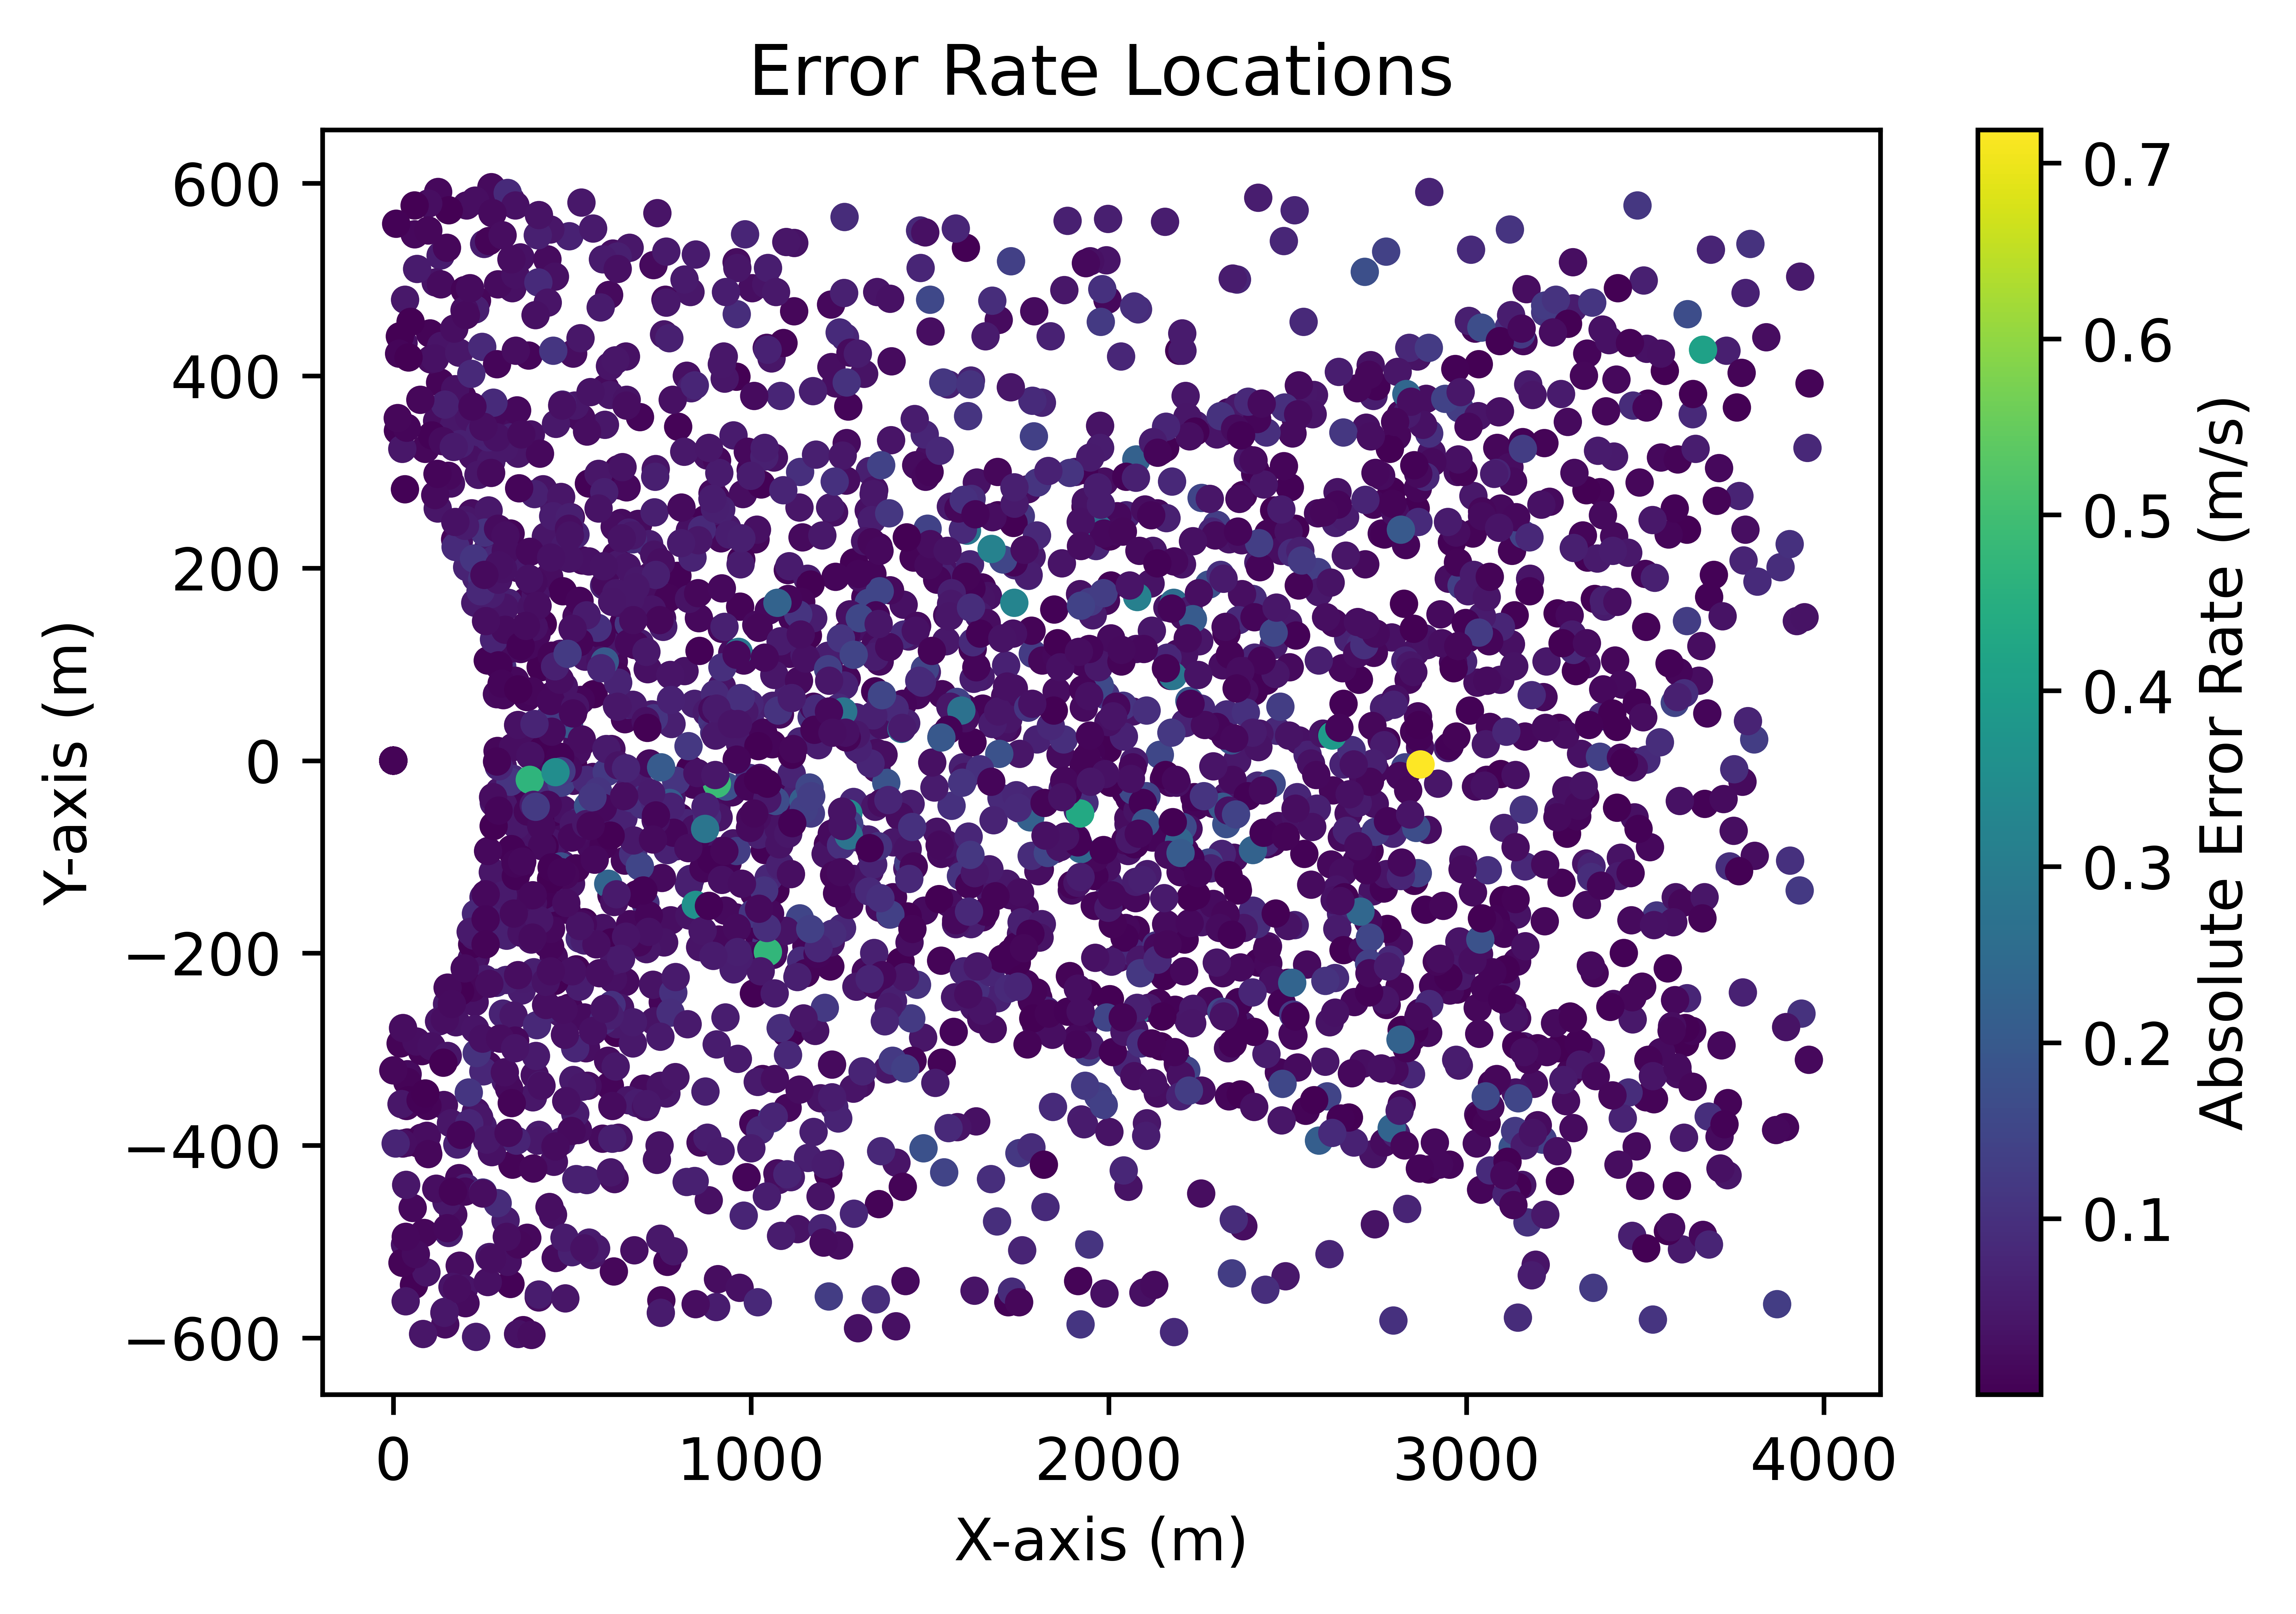

In [72]:
#all_predictions = dnn_model.predict(X).flatten()
a = plt.axes
error_all=np.abs(all_predictions-Y)
plt.figure(dpi=1200)
plt.scatter(dataset_pos[:,0], dataset_pos[:,1],c=error_all, cmap='viridis', s=15)
#plt.scatter(train_features["Fingerprint(G2)"], train_features["Fingerprint(G4)"],c=train_labels)
#plt.scatter(train_labels, train_predictions)
plt.xlabel('X-axis (m)')
plt.ylabel('Y-axis (m)')
plt.title('Error Rate Locations')
cbar=plt.colorbar()
cbar.set_label('Absolute Error Rate (m/s)')

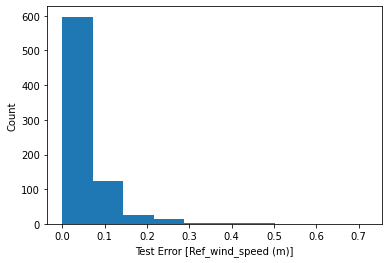

In [73]:
error_test = np.abs(test_predictions - Y_test)
plt.hist(error_test, bins=10)
plt.xlabel('Test Error [Ref_wind_speed (m)]')
_ = plt.ylabel('Count')

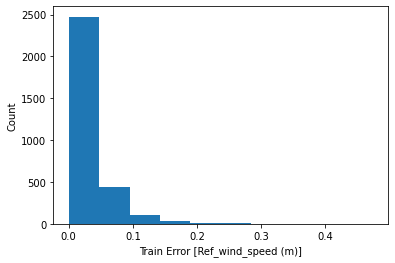

In [74]:
error_train = np.abs(train_predictions - Y_train)
plt.hist(error_train, bins=10)
plt.xlabel('Train Error [Ref_wind_speed (m)]')
_ = plt.ylabel('Count')

In [27]:
print("Max test error:",np.max(error_test))
print("Mean test error:",np.mean(error_test))

Max test error: 0.7189588701660163
Mean test error: 0.048368589682482054


In [28]:
print("Max all error:",np.max(error_all))
print("Mean all error:",np.mean(error_all))

Max all error: 0.7189588701660163
Mean all error: 0.03299227415829849


In [29]:
print("Max train error:",np.max(error_train))
print("Mean train error:",np.mean(error_train))

Max train error: 0.47445873502197244
Mean train error: 0.029148193802658515


In [30]:
dnn_model.save('dnn_model')

2023-08-01 19:08:40.409434: W tensorflow/python/util/util.cc:368] Sets are not currently considered sequences, but this may change in the future, so consider avoiding using them.


INFO:tensorflow:Assets written to: dnn_model/assets


In [ ]:
import matplotlib.cm as cm
plt.scatter(dataset['Fingerprint(G4)'],dataset['Fingerprint(G2)'], c=dataset['Ref_Wind_Speed'], s=10, cmap=cm.bwr)
cbar= plt.colorbar()
plt.xlabel('Fingerprint(G4)')
plt.ylabel('Fingerprint(G2)')
plt.show()

In [ ]:
# dnn_model.evaluate(test_features, test_labels, verbose=0)

In [ ]:
# import numpy
# from mayavi.mlab import *

# def test_points3d():


#     x = all_features["Fingerprint(G2)"]
#     y = all_features["Fingerprint(G4)"]
#     z = all_features["Fingerprint(G6)"]
#     s = error_all
#     colorbar(orientation='vertical')
#     xlabel('Fingerprint(G2)')
#     ylabel('Fingerprint(G4)')
#     zlabel('Fingerprint(G6)')
#     return points3d(x, y, z, s, colormap="blue-red", scale_factor=0.05)
# test_points3d()
# #colorbar(object=all_labels, title="Points in Mayavi")
# #view()
# show()